1. Implement Auto-Encoder for latent representation of MNIST dataset.

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [50]:
batch_size = 128
learning_rate = 1e-3
num_epochs = 20
latent_dim = 32

In [51]:
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [52]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, latent_dim),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

In [53]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [54]:
model.train()
for epoch in range(num_epochs):
    for images, _ in train_loader:
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/20], Loss: 0.0261
Epoch [2/20], Loss: 0.0177
Epoch [3/20], Loss: 0.0150
Epoch [4/20], Loss: 0.0130
Epoch [5/20], Loss: 0.0099
Epoch [6/20], Loss: 0.0104
Epoch [7/20], Loss: 0.0099
Epoch [8/20], Loss: 0.0094
Epoch [9/20], Loss: 0.0084
Epoch [10/20], Loss: 0.0087
Epoch [11/20], Loss: 0.0075
Epoch [12/20], Loss: 0.0076
Epoch [13/20], Loss: 0.0076
Epoch [14/20], Loss: 0.0068
Epoch [15/20], Loss: 0.0066
Epoch [16/20], Loss: 0.0072
Epoch [17/20], Loss: 0.0071
Epoch [18/20], Loss: 0.0071
Epoch [19/20], Loss: 0.0074
Epoch [20/20], Loss: 0.0067


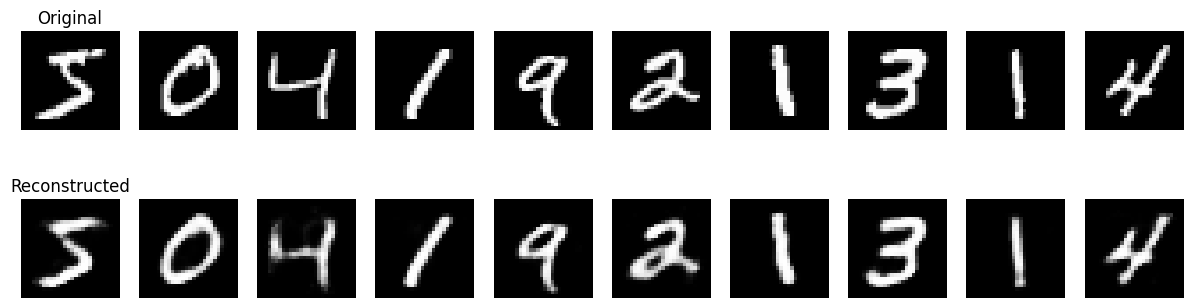

In [55]:
def visualize(model, dataset):
    model.eval()
    sample_data = next(iter(DataLoader(dataset, batch_size=10)))
    images, _ = sample_data
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
    
    fig, axes = plt.subplots(2, 10, figsize=(15, 4))
    for i in range(10):
        axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(outputs[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
    axes[0, 0].set_title('Original')
    axes[1, 0].set_title('Reconstructed')
    plt.show()

visualize(model, train_dataset)

2. Implement VAE for synthesizing digits using MNIST training data.

In [56]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 400),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

In [57]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [58]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [59]:
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}')

Epoch 1, Loss: 167.2855
Epoch 2, Loss: 124.0483
Epoch 3, Loss: 115.8008
Epoch 4, Loss: 112.3023
Epoch 5, Loss: 110.2664
Epoch 6, Loss: 108.9724
Epoch 7, Loss: 108.0492
Epoch 8, Loss: 107.2863
Epoch 9, Loss: 106.7611
Epoch 10, Loss: 106.3133
Epoch 11, Loss: 105.9759
Epoch 12, Loss: 105.6088
Epoch 13, Loss: 105.3814
Epoch 14, Loss: 105.1336
Epoch 15, Loss: 104.9012
Epoch 16, Loss: 104.7102
Epoch 17, Loss: 104.5931
Epoch 18, Loss: 104.4028
Epoch 19, Loss: 104.2008
Epoch 20, Loss: 104.1135


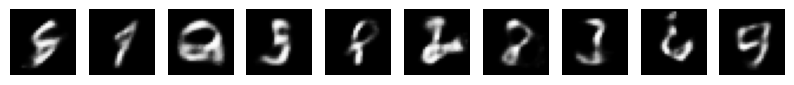

In [68]:
def generate_samples(model, n=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n, latent_dim).to(device)
        samples = model.decoder(z).view(-1, 1, 28, 28).cpu()
    
    fig, axes = plt.subplots(1, n, figsize=(n, 1))
    for i in range(n):
        axes[i].imshow(samples[i].squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.show()

generate_samples(model)